In [1]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 10 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 4
cfg['set_id'] = 6

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [8]:
from dataloader import *
from models import *
import time

model = GRU_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [9]:
model.train()

GRU_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (gru): GRU(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [10]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 1.67536
count = 4, loss = 0.90956
count = 6, loss = 0.84955
count = 8, loss = 0.63299
count = 10, loss = 0.70894
count = 12, loss = 0.73851
count = 14, loss = 0.67447
validation loss: 0.610238641500473
epoch finished: 1
count = 2, loss = 0.49947
count = 4, loss = 0.51012
count = 6, loss = 0.51408
count = 8, loss = 0.37424
count = 10, loss = 0.48992
count = 12, loss = 0.45021
count = 14, loss = 0.43205
validation loss: 0.4022481381893158
epoch finished: 2
count = 2, loss = 0.37432
count = 4, loss = 0.33646
count = 6, loss = 0.39781
count = 8, loss = 0.31017
count = 10, loss = 0.30422
count = 12, loss = 0.35200
count = 14, loss = 0.24465
validation loss: 0.36421615481376646
epoch finished: 3
count = 2, loss = 0.28293
count = 4, loss = 0.22482
count = 6, loss = 0.28493
count = 8, loss = 0.24036
count = 10, loss = 0.26232
count = 12, loss = 0.31864
count = 14, loss = 0.23873
validation loss: 0.432256680727005
epoch finished: 4
count = 2, loss = 0.27234
count = 4, loss = 0

In [13]:
np.save('val_loss_gru_set6.npy', val_losses)
np.save('train_loss_gru_set6.npy', train_losses)

In [18]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.4911575734615326
validation MAE: 0.13511062562465667
QWK Score: 0.6318619464818869


In [24]:
model = load_model(LSTM_Score, './models/s6_ba120e13b14.pt', cfg)
valid_indices = list(range(len(valid_data)))

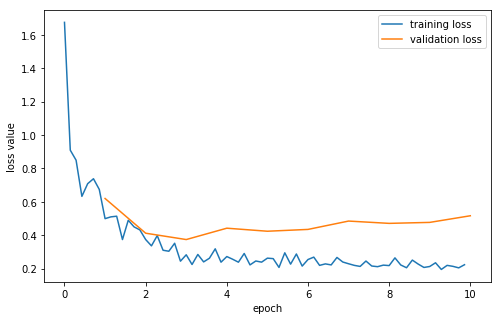

In [17]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.01,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [19]:
targets

[array([3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 1, 2, 3, 3, 3, 2, 3, 2, 2, 3, 1, 4,
        2, 2, 4, 3, 4, 3, 4, 3, 1, 3, 3, 2, 3, 3, 2, 3, 1, 2, 4, 1, 3, 3,
        3, 2, 3, 3, 2, 4, 3, 3, 2, 3, 3, 1, 3, 3, 2, 3, 2, 3, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 4, 4, 4, 3, 4, 2, 3, 3, 3, 3, 2, 3,
        3, 3, 2, 2, 3, 3, 3, 4, 2, 2, 4, 0, 3, 3, 2, 3, 3, 3, 3, 1, 3, 1,
        3, 2, 2, 4, 3, 1, 3, 3, 3, 3]),
 array([2, 1, 4, 2, 3, 3, 2, 2, 3, 1, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3,
        3, 3, 3, 3, 4, 3, 3, 3, 2, 3, 3, 2, 3, 3, 0, 4, 4, 3, 3, 2, 3, 2,
        3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 1, 3,
        2, 3, 2, 4, 3, 2, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 1,
        3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 4, 3, 3, 4, 3, 3, 3, 4, 2, 3, 3, 3,
        4, 3, 3, 1, 2, 3, 4, 1, 3, 0]),
 array([4, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 1, 3, 3, 2, 3, 4, 4, 2, 2,
        3, 2, 3, 1, 4, 2, 3, 3, 4, 3, 3, 3, 1, 3, 1, 1, 3, 2, 4, 4, 3, 2,
        2, 3, 3, 3, 4, 2, 3, 3, 

In [21]:
preds

[array([4, 4, 4, 3, 3, 4, 4, 3, 3, 4, 0, 2, 2, 2, 4, 2, 3, 3, 1, 3, 1, 4,
        3, 1, 2, 3, 4, 4, 4, 1, 1, 1, 3, 2, 2, 3, 3, 3, 1, 3, 4, 2, 3, 3,
        3, 3, 2, 3, 2, 4, 3, 4, 2, 3, 3, 1, 3, 4, 4, 4, 2, 4, 2, 4, 2, 3,
        3, 3, 4, 2, 4, 1, 3, 2, 3, 3, 4, 4, 2, 2, 3, 4, 2, 3, 3, 2, 3, 2,
        3, 3, 2, 2, 4, 3, 3, 3, 3, 3, 4, 1, 2, 4, 2, 3, 1, 3, 3, 1, 3, 0,
        4, 3, 4, 3, 2, 1, 1, 3, 3, 2]),
 array([1, 1, 3, 1, 3, 4, 2, 1, 3, 2, 2, 3, 2, 4, 2, 3, 2, 3, 1, 3, 2, 3,
        3, 3, 4, 2, 4, 4, 2, 4, 1, 3, 3, 1, 3, 2, 1, 4, 4, 3, 3, 2, 3, 2,
        3, 2, 3, 3, 1, 4, 2, 3, 1, 2, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 2,
        1, 3, 2, 4, 3, 3, 4, 4, 2, 4, 4, 4, 1, 3, 4, 2, 2, 2, 4, 3, 3, 0,
        2, 4, 4, 3, 3, 2, 2, 3, 3, 3, 4, 3, 3, 4, 2, 3, 3, 4, 3, 3, 4, 3,
        4, 4, 4, 1, 1, 3, 4, 3, 3, 1]),
 array([3, 2, 3, 3, 3, 3, 2, 1, 2, 3, 4, 2, 3, 1, 2, 4, 3, 2, 4, 3, 2, 1,
        3, 3, 3, 1, 4, 3, 3, 3, 4, 3, 3, 4, 1, 3, 1, 1, 4, 2, 4, 3, 4, 3,
        3, 3, 2, 4, 1, 2, 3, 4, 

In [22]:
train_losses

[1.6753589510917664,
 0.9095585942268372,
 0.849550873041153,
 0.6329919099807739,
 0.7089409232139587,
 0.7385136485099792,
 0.6744676530361176,
 0.49946871399879456,
 0.5101154893636703,
 0.5140819251537323,
 0.3742351531982422,
 0.4899158328771591,
 0.45020730793476105,
 0.4320537894964218,
 0.37432482838630676,
 0.33646394312381744,
 0.39780913293361664,
 0.3101668804883957,
 0.3042243868112564,
 0.35199765861034393,
 0.2446512207388878,
 0.2829260379076004,
 0.22481632232666016,
 0.2849317491054535,
 0.2403634786605835,
 0.26231979578733444,
 0.31864018738269806,
 0.23872682452201843,
 0.2723357230424881,
 0.2563934326171875,
 0.23861055821180344,
 0.29083390533924103,
 0.22241686284542084,
 0.24578320980072021,
 0.23887570947408676,
 0.26279178261756897,
 0.25989236682653427,
 0.20724693685770035,
 0.2947622388601303,
 0.22690065950155258,
 0.28764647245407104,
 0.2152605727314949,
 0.25456100702285767,
 0.2689730152487755,
 0.21952970325946808,
 0.22842787206172943,
 0.222296662

In [23]:
val_losses

[0.610238641500473,
 0.4022481381893158,
 0.36421615481376646,
 0.432256680727005,
 0.41406593918800355,
 0.42495009303092957,
 0.474969881772995,
 0.461185884475708,
 0.4670137524604797,
 0.5067275106906891]